## Create A Network Grid from Raster Grid

This notebook demonstrates how to extract a NetworkModelGrid from a RasterModelGrid using the 'create_network_from_raster' function

In [1]:
import os
import pathlib
import matplotlib.pyplot as plt
import numpy as np
from collections import OrderedDict
import pandas as pd

#landlab modules
from landlab.grid.network import NetworkModelGrid
from landlab.plot import graph
from landlab import RasterModelGrid
from landlab.io import read_esri_ascii
from landlab import imshow_grid_at_node
from landlab.components import FlowAccumulator, ChannelProfiler
from landlab.components import DepressionFinderAndRouter
# Package for plotting raster data
from landlab.plot.imshow import imshow_grid, imshow_grid_at_node
from landlab.grid.create_network import create_network_from_raster

c:\users\sahrendt\documents\github\landlab\landlab\grid\create_network.py:247: SyntaxWarning: "is" with a literal. Did you mean "=="?
  if method is 'variable':
c:\users\sahrendt\documents\github\landlab\landlab\grid\create_network.py:255: SyntaxWarning: "is" with a literal. Did you mean "=="?
  if method is 'constant':


## Import a DEM
Setup this notebook to draw DEM data for the Hugo Site from the overland_flow tutorial folder.

In [2]:
tutorial_dir = os.path.dirname(os.getcwd())
raster_fn = os.path.join(tutorial_dir, 'overland_flow/hugo_site.asc') #mac
# raster_fn = os.path.join(tutorial_dir, 'overland_flow\\hugo_site.asc') #windows

## Create a Raster Model Grid

Now let's create a raster model grid from the .asc data

In [3]:
rmg, z = read_esri_ascii(raster_fn, name='topographic__elevation')
rmg.status_at_node[rmg.nodes_at_right_edge] = rmg.BC_NODE_IS_FIXED_VALUE
rmg.status_at_node[np.isclose(z, -9999.)] = rmg.BC_NODE_IS_CLOSED

Visualize Basin topography

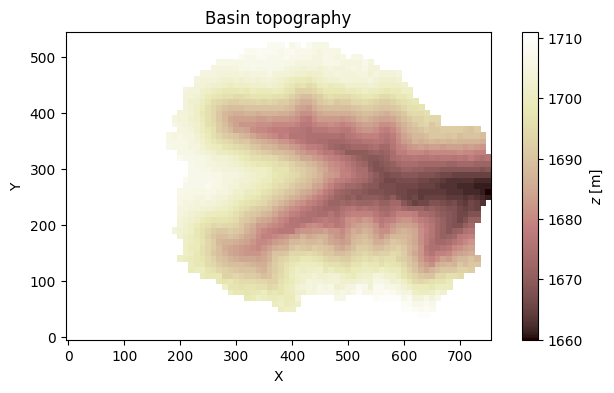

In [4]:
plt.figure(figsize=(8,4))
imshow_grid(rmg, 'topographic__elevation',
            plot_name="Basin topography",
            color_for_closed=None,
            colorbar_label="$z$ [m]")
plt.show()

## Create  a Network Model Grid

Now let's create a network model grid using the 'create_network_from_raster' function:

In [5]:
nmg = create_network_from_raster(
    rmg,
    method='variable', 
    n_widths=20,
    # node_spacing=30,
    min_channel_thresh=12000,
    fields=['drainage_area', 'topographic__elevation'])

## Let's plot our network

In [6]:
# Package for plotting networks
from landlab.plot import graph

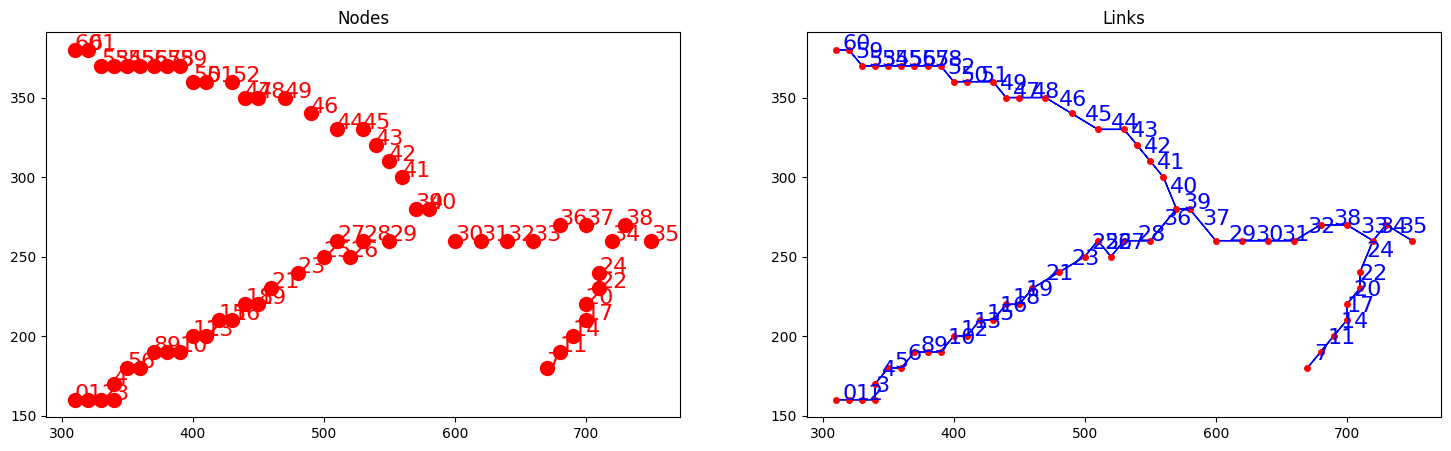

In [7]:
## Plot nodes
plt.figure(figsize=(18,5))
plt.subplot(1,2,1)
graph.plot_nodes(nmg)
plt.title("Nodes")

## Plot nodes + links
plt.subplot(1,2,2)
graph.plot_nodes(nmg,with_id=False,markersize=4)
graph.plot_links(nmg)
plt.title("Links")
plt.show()

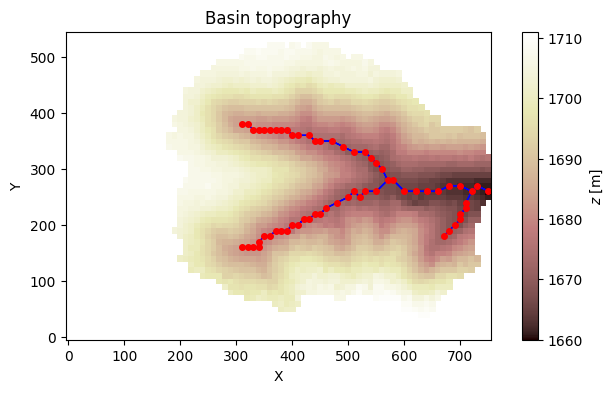

In [8]:
plt.figure(figsize=(8,4))
graph.plot_nodes(nmg,with_id=False,markersize=4)
graph.plot_links(nmg,with_id=False)
imshow_grid(rmg, 'topographic__elevation',
            plot_name="Basin topography",
            color_for_closed=None,
            colorbar_label="$z$ [m]")
plt.show()

In [9]:
len(nmg.nodes_at_link), len(nmg.nodes)

(61, 62)

In [11]:
if len(nmg.nodes_at_link) > (len(nmg.nodes) - 1):
    print('there are duplicate links')
else:
    print('link count looks good!')

link count looks good!
